In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import json
import geopandas as gpd
import folium
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)
from uszipcode import SearchEngine
import plotly.graph_objects as go

/Users/backup/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
resids_df=pd.read_csv('../../data/sarimax_resids_acs_bikeshare.csv', 
                      dtype={'Unnamed: 0': str}).rename(columns = {"Unnamed: 0":"zip"})

In [3]:
zipcodes = resids_df['zip'].unique()

In [4]:
zips_geo_df = pd.read_csv('../../data/georef-united-states-of-america-zc-point.csv',
                          sep=';', dtype={'Zip Code': str})

In [5]:
zips_geo_df['Zip Code'] = zips_geo_df['Zip Code'].map(lambda x: '0' + x if len(x) < 5 else x)

In [6]:
zips_geo_df = zips_geo_df.loc[zips_geo_df['Zip Code'].isin(zipcodes)]
zips_geo_df['Zip Code'].nunique()

1301

In [10]:
zips_geo_df

,Zip Code,Official USPS city name,Official USPS State Code,Official State Name,ZCTA,ZCTA parent,Population,Density,Primary Official County Code,Primary Official County Name,County Weights,Official County Name,Official County Code,Imprecise,Military,Timezone,Geo Point
15,32224,Jacksonville,FL,Florida,True,NaN,44058.0,803.8,12031,Duval,"{""12031"": ""99.89"", ""12109"": ""0.11""}",Duval|St. Johns,12031|12109,False,False,America/New_York,"30.27027,-81.46796"
32,33634,Tampa,FL,Florida,True,NaN,22719.0,1069.3,12057,Hillsborough,"{""12057"": ""100""}",Hillsborough,12057,False,False,America/New_York,"28.00884,-82.54618"
38,34698,Dunedin,FL,Florida,True,NaN,38720.0,1463.7,12103,Pinellas,"{""12103"": ""100""}",Pinellas,12103,False,False,America/New_York,"28.03399,-82.77961"
136,43204,Columbus,OH,Ohio,True,NaN,42796.0,1837.5,39049,Franklin,"{""39049"": ""100""}",Franklin,39049,False,False,America/New_York,"39.96136,-83.0816"
191,46203,Indianapolis,IN,Indiana,True,NaN,38581.0,1076.1,18097,Marion,"{""18097"": ""100""}",Marion,18097,False,False,America/Indiana/Indianapolis,"39.73761,-86.0969"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33000,22204,Arlington,VA,Virginia,True,NaN,54617.0,5117.9,51013,Arlington,"{""51013"": ""100""}",Arlington,51013,False,False,America/New_York,"38.86083,-77.09894"
33010,23602,Newport News,VA,Virginia,True,NaN,38821.0,1117.9,51700,Newport News,"{""51700"": ""99.76"", ""51199"": ""0.24""}",Newport News|York,51700|51199,False,False,America/New_York,"37.1148,-76.51582"
33057,27705,Durham,NC,North Carolina,True,NaN,49508.0,436.5,37063,Durham,"{""37063"": ""90.43"", ""37135"": ""9.57""}",Durham|Orange,37063|37135,False,False,America/New_York,"36.02698,-78.98065"
33098,30308,Atlanta,GA,Georgia,True,NaN,18839.0,4561.5,13121,Fulton,"{""13121"": ""100""}",Fulton,13121,False,False,America/New_York,"33.77121,-84.3781"


In [7]:
XGB_resids_auto_only_df=pd.read_csv('../../data/residuals_XGB-zri_minmax.csv', 
                      dtype={'zip': str})

In [8]:
XGB_resids_auto_only_df['zip'] = XGB_resids_auto_only_df['zip'].map(lambda x: '0' + x if len(x) < 5 else x)

In [9]:
XGB_resids_auto_only_df['residual']=XGB_resids_auto_only_df['zri_predict']-XGB_resids_auto_only_df['zri_actual']
XGB_resids_auto_only_df['residual_squared']=XGB_resids_auto_only_df['residual'].map(lambda x: x**2)
rmse_table=XGB_resids_auto_only_df.groupby('zip')[['residual_squared']].agg(['sum','count'])
rmse_table['residual_avgd']=rmse_table['residual_squared']['sum']/rmse_table['residual_squared']['count']
rmse_table['residual_avgd']=rmse_table['residual_avgd'].apply(lambda x: x**0.5)
rmse_XGB_resids_auto_only_df = rmse_table[['residual_avgd']].reset_index().rename(columns={'residual_avgd': "RMSE"})


In [21]:
rmse_XGB_resids_auto_only_df.columns = ['zip', 'rmse']

In [22]:
zip_county_merged = rmse_XGB_resids_auto_only_df.merge(zips_geo_df,
                                                       how= 'left', 
                                                       left_on= "zip", 
                                                       right_on = "Zip Code")

In [23]:
zip_county_merged

,zip,rmse,Zip Code,Official USPS city name,Official USPS State Code,Official State Name,ZCTA,ZCTA parent,Population,Density,Primary Official County Code,Primary Official County Name,County Weights,Official County Name,Official County Code,Imprecise,Military,Timezone,Geo Point
0,01013,24.671651,01013,Chicopee,MA,Massachusetts,True,NaN,22733.0,1558.3,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.1595,-72.60825"
1,01020,41.318925,01020,Chicopee,MA,Massachusetts,True,NaN,30108.0,928.1,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.17637,-72.56538"
2,01040,42.089509,01040,Holyoke,MA,Massachusetts,True,NaN,40241.0,734.1,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.21256,-72.64107"
3,01085,10.602525,01085,Westfield,MA,Massachusetts,True,NaN,41780.0,270.2,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.15371,-72.76958"
4,01104,30.604603,01104,Springfield,MA,Massachusetts,True,NaN,23740.0,1757.3,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.13404,-72.56679"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,99207,100.555839,99207,Spokane,WA,Washington,True,NaN,30411.0,2155.6,53063,Spokane,"{""53063"": ""100""}",Spokane,53063,False,False,America/Los_Angeles,"47.68889,-117.38782"
1297,99501,49.905342,99501,Anchorage,AK,Alaska,True,NaN,16679.0,927.8,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.22035,-149.85702"
1298,99504,56.971770,99504,Anchorage,AK,Alaska,True,NaN,42341.0,2566.5,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.20399,-149.74703"
1299,99508,38.350270,99508,Anchorage,AK,Alaska,True,NaN,36560.0,2033.6,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.2007,-149.81448"


In [46]:
# 

bins = pd.IntervalIndex.from_tuples([(0, 500), (500, 1000), (1000, 100000)])
zip_county_merged['buckets'] = pd.cut(zip_county_merged['Density'], bins=[0, 500, 1000, 1000000], labels=['Rural', 'Suburban', 'Urban'])

In [47]:
zip_county_merged

,zip,rmse,Zip Code,Official USPS city name,Official USPS State Code,Official State Name,ZCTA,ZCTA parent,Population,Density,Primary Official County Code,Primary Official County Name,County Weights,Official County Name,Official County Code,Imprecise,Military,Timezone,Geo Point,buckets
0,01013,24.671651,01013,Chicopee,MA,Massachusetts,True,NaN,22733.0,1558.3,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.1595,-72.60825",Urban
1,01020,41.318925,01020,Chicopee,MA,Massachusetts,True,NaN,30108.0,928.1,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.17637,-72.56538",Suburban
2,01040,42.089509,01040,Holyoke,MA,Massachusetts,True,NaN,40241.0,734.1,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.21256,-72.64107",Suburban
3,01085,10.602525,01085,Westfield,MA,Massachusetts,True,NaN,41780.0,270.2,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.15371,-72.76958",Rural
4,01104,30.604603,01104,Springfield,MA,Massachusetts,True,NaN,23740.0,1757.3,25013,Hampden,"{""25013"": ""100""}",Hampden,25013,False,False,America/New_York,"42.13404,-72.56679",Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296,99207,100.555839,99207,Spokane,WA,Washington,True,NaN,30411.0,2155.6,53063,Spokane,"{""53063"": ""100""}",Spokane,53063,False,False,America/Los_Angeles,"47.68889,-117.38782",Urban
1297,99501,49.905342,99501,Anchorage,AK,Alaska,True,NaN,16679.0,927.8,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.22035,-149.85702",Suburban
1298,99504,56.971770,99504,Anchorage,AK,Alaska,True,NaN,42341.0,2566.5,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.20399,-149.74703",Urban
1299,99508,38.350270,99508,Anchorage,AK,Alaska,True,NaN,36560.0,2033.6,2020,Anchorage,"{""02020"": ""100""}",Anchorage,2020,False,False,America/Anchorage,"61.2007,-149.81448",Urban


In [57]:
zip_buckets = zip_county_merged.groupby('buckets').agg(mean = ('rmse', 'mean'))

In [58]:
zip_buckets

,mean
buckets,
Rural,45.625982
Suburban,41.690857
Urban,56.376988


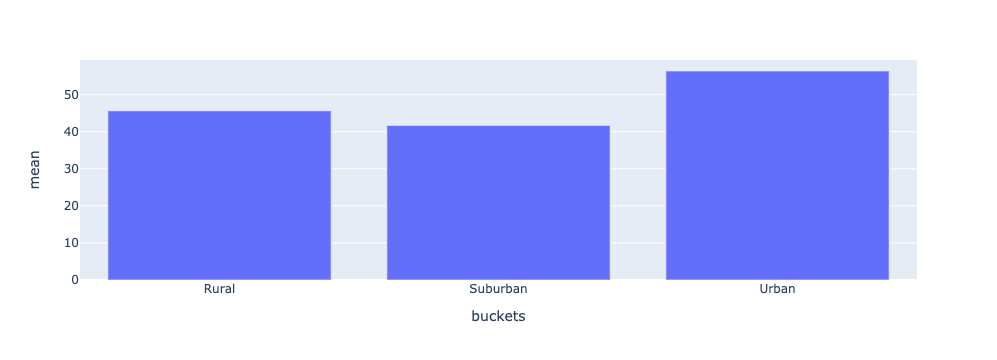

In [63]:
import plotly.express as px
fig = px.bar(zip_buckets, x=zip_buckets.index, y="mean")
fig.show()